In [2]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import pytz
from pandas.tseries.holiday import USFederalHolidayCalendar

try: import setGPU
except ImportError: pass

import torch

import model_classes, nets
from constants import *

import matplotlib.pyplot as plt
import tkinter
import matplotlib
import matplotlib.pyplot as plt

from model_classes import InterpretableNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_data_with_features(filename):
    tz = pytz.timezone("America/New_York")
    df = pd.read_csv(filename, sep=" ", header=None, usecols=[1,2,3], 
        names=["time","load","temp"])
    df["time"] = df["time"].apply(dt.fromtimestamp, tz=tz)
    df["date"] = df["time"].apply(lambda x: x.date())
    df["hour"] = df["time"].apply(lambda x: x.hour)
    df.drop_duplicates("time", inplace=True)

    # Create one-day tables and interpolate missing entries
    df_load = df.pivot(index="date", columns="hour", values="load")
    df_temp = df.pivot(index="date", columns="hour", values="temp")
    df_load = df_load.transpose().fillna(method="backfill").transpose()
    df_load = df_load.transpose().fillna(method="ffill").transpose()
    df_temp = df_temp.transpose().fillna(method="backfill").transpose()
    df_temp = df_temp.transpose().fillna(method="ffill").transpose()

    holidays = USFederalHolidayCalendar().holidays(
        start='2008-01-01', end='2016-12-31').to_pydatetime()
    holiday_dates = set([h.date() for h in holidays])

    s = df_load.reset_index()["date"]
    data={"weekend": s.apply(lambda x: x.isoweekday() >= 6).values,
          "holiday": s.apply(lambda x: x in holiday_dates).values,
          "dst": s.apply(lambda x: tz.localize(
            dt.combine(x, dt.min.time())).dst().seconds > 0).values,
          "cos_doy": s.apply(lambda x: np.cos(
            float(x.timetuple().tm_yday)/365*2*np.pi)).values,
          "sin_doy": s.apply(lambda x: np.sin(
            float(x.timetuple().tm_yday)/365*2*np.pi)).values}
    df_feat = pd.DataFrame(data=data, index=df_load.index)

    # Construct features and normalize (all but intercept)
    X = np.hstack([df_load.iloc[:-1].values,        # past load
                    df_temp.iloc[:-1].values,       # past temp
                    df_temp.iloc[:-1].values**2,    # past temp^2
                    df_temp.iloc[1:].values,        # future temp
                    df_temp.iloc[1:].values**2,     # future temp^2
                    df_temp.iloc[1:].values**3,     # future temp^3
                    df_feat.iloc[1:].values,        
                    np.ones((len(df_feat)-1, 1))]).astype(np.float64)
    # X[:,:-1] = \
    #     (X[:,:-1] - np.mean(X[:,:-1], axis=0)) / np.std(X[:,:-1], axis=0)

    Y = df_load.iloc[1:].values

    return X, Y

In [4]:
X1, Y1 = load_data_with_features('pjm_load_data_2008-11.txt')
X2, Y2 = load_data_with_features('pjm_load_data_2012-16.txt')

X = np.concatenate((X1, X2), axis=0)
X[:,:-1] = (X[:,:-1] - np.mean(X[:,:-1], axis=0)) / np.std(X[:,:-1], axis=0)

Y = np.concatenate((Y1, Y2), axis=0)

# Train, test split.
n_tt = int(len(X) * 0.8)
X_train, Y_train = X[:n_tt], Y[:n_tt]
X_test, Y_test = X[n_tt:], Y[n_tt:]

# Construct tensors (without intercepts).
X_train_ = torch.tensor(X_train[:,:-1], dtype=torch.float, device=DEVICE)
Y_train_ = torch.tensor(Y_train, dtype=torch.float, device=DEVICE)
X_test_ = torch.tensor(X_test[:,:-1], dtype=torch.float, device=DEVICE)
Y_test_ = torch.tensor(Y_test, dtype=torch.float, device=DEVICE)
variables_rmse = {'X_train_': X_train_, 'Y_train_': Y_train_, 
            'X_test_': X_test_, 'Y_test_': Y_test_}

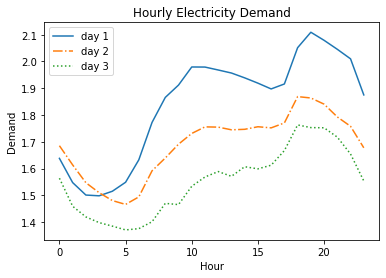

In [4]:
plt.plot(range(24), Y_train[0,:], label='day 1')
plt.plot(range(24), Y_train[3,:], label='day 2', linestyle='-.')
plt.plot(range(24), Y_train[4,:], label='day 3', linestyle=':')
# plt.plot(range(24), np.mean(Y_train, axis=0))
# plt.boxplot(Y_train)
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.title('Hourly Electricity Demand')
plt.legend()
plt.show()

In [5]:
params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}

In [6]:
# Run and eval rmse-minimizing net
model_rmse = model_classes.Net(X_train[:,:-1], Y_train, [200, 200])
model_rmse = nets.run_rmse_net(model_rmse, variables_rmse, X_train, Y_train, EPOCHS=1000)
# results = nets.eval_net("rmse_net", model_rmse, variables_rmse, params)

0 0.21088506281375885 0.036538172513246536
1 0.15733739733695984 0.03917917236685753
2 0.12118426710367203 0.029688846319913864
3 0.09979812800884247 0.02207053080201149
4 0.09125882387161255 0.02000569924712181
5 0.08499772101640701 0.02035219594836235
6 0.07860446721315384 0.021040959283709526
7 0.07234562933444977 0.02107003517448902
8 0.0682692900300026 0.020453276112675667
9 0.06562962383031845 0.019829068332910538
10 0.06220254674553871 0.019817130640149117
11 0.05835634097456932 0.02025688998401165
12 0.05431104823946953 0.02095952071249485
13 0.052025094628334045 0.021242346614599228
14 0.04917990788817406 0.021351514384150505
15 0.04635715112090111 0.021024394780397415
16 0.04401853308081627 0.020397435873746872
17 0.04275502637028694 0.019572554156184196
18 0.041024912148714066 0.01866219937801361
19 0.039449144154787064 0.018007026985287666
20 0.03785412386059761 0.017488732933998108
21 0.036528728902339935 0.016862116754055023
22 0.03673648461699486 0.01616736873984337
23 0

In [7]:
def task_loss(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
            params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0)).mean(0)

In [8]:
from model_classes import SolvePointQP
p = model_rmse(torch.tensor(X_test[:,:-1]).float())[0]
decision = SolvePointQP(params)(p)[:,:params["n"]]

n: 24


c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\electricity\model_classes.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ramp_h = torch.tensor(self.c_ramp * torch.ones((self.n - 1) * 2)).double()


In [9]:
error = task_loss(decision, torch.tensor(Y_test), params) / len(Y_test) 
print("2-stage cost", error.mean())

2-stage cost tensor(0.0020, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [10]:
interpretable_model = InterpretableNet(X_train[:,:-1], Y_train, model_rmse, params)

n: 24


In [19]:
interpretable_model.train(EPOCHS=100)

c:\Users\rares\Dropbox (MIT)\Documents\documents\mit\research\interpretable-end-to-end\electricity\model_classes.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ramp_h = self.ramp_h.unsqueeze(0).expand(nBatch, ramp_h.size(0))


AttributeError: 'SolvePointQP' object has no attribute 'ramp_h'

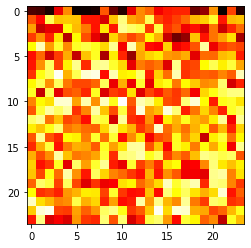

In [17]:
weights = interpretable_model.mean_forecast.detach().numpy()
plt.imshow(weights, cmap='hot', interpolation='nearest')

In [13]:
torch.sigmoid(interpretable_model.quantiles)

tensor([0.7056, 0.5155, 0.5615, 0.6261, 0.5411, 0.6312, 0.5626, 0.5385, 0.6492,
        0.6839, 0.5354, 0.5898, 0.7174, 0.6541, 0.6499, 0.7336, 0.7063, 0.5779,
        0.7109, 0.5668, 0.7250, 0.7227, 0.6522, 0.7137],
       grad_fn=<SigmoidBackward0>)

In [14]:
interpretable_model.predict(torch.tensor(X_test[:,:-1]).float())

tensor([[1.6660, 1.5535, 1.5235,  ..., 1.9758, 1.9054, 1.8166],
        [1.7332, 1.6256, 1.5938,  ..., 2.0630, 1.9861, 1.8914],
        [1.6951, 1.5841, 1.5448,  ..., 1.8893, 1.8404, 1.7708],
        ...,
        [1.3712, 1.2520, 1.2138,  ..., 1.7830, 1.6984, 1.5841],
        [1.4178, 1.2967, 1.2581,  ..., 1.7128, 1.6321, 1.5306],
        [1.3639, 1.2432, 1.2068,  ..., 1.6697, 1.5960, 1.4964]],
       grad_fn=<AddBackward0>)

In [15]:
p

tensor([[1.5844, 1.5091, 1.4749,  ..., 1.8798, 1.8266, 1.7239],
        [1.6504, 1.5794, 1.5440,  ..., 1.9654, 1.9057, 1.7971],
        [1.6148, 1.5413, 1.4979,  ..., 1.7947, 1.7634, 1.6797],
        ...,
        [1.2928, 1.2132, 1.1700,  ..., 1.6919, 1.6249, 1.4960],
        [1.3396, 1.2580, 1.2141,  ..., 1.6218, 1.5587, 1.4427],
        [1.2865, 1.2056, 1.1638,  ..., 1.5798, 1.5237, 1.4095]],
       grad_fn=<AddBackward0>)